<a href="https://colab.research.google.com/github/jvataidee/pdi_python/blob/main/Integra%C3%A7%C3%A3o_fusao_e_operacoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Integração de bandas e Operações Aritimétricas**

### Instalando bibliotecas

In [ ]:
!pip install spectral
!pip install rasterio

### Importando bibliotecas

In [54]:
#Bibliotecas
import numpy as np
import rasterio as rio
import matplotlib
from spectral import imshow
import skimage.color as color
from skimage.transform import rescale
import cv2

# Bibliotecas
import numpy as np
import rasterio as rio
import tifffile as tif
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster

## Integração de bandas

In [4]:
# Lendo multiespectral
src1 = rio.open('/content/drive/MyDrive/pdi_python/21 - PDI com Python/02 - Transformações Espectrais e Espaciais/mult.tif')
b1 = src1.read(1)
b2 = src1.read(2)
b3 = src1.read(3)
b4 = src1.read(4)

multi = np.dstack([b1,b2,b3,b4])

In [5]:
# Lendo banda pan
src2 = rio.open('/content/drive/MyDrive/pdi_python/21 - PDI com Python/02 - Transformações Espectrais e Espaciais/pan_cut.tif')
pan = src2.read(1)

In [6]:
# Lendo imagem SAR
src3 = rio.open('/content/drive/MyDrive/pdi_python/21 - PDI com Python/02 - Transformações Espectrais e Espaciais/VH.tif')
sar = src3.read(1)

In [7]:
print(multi.shape, sar.shape, pan.shape)

(635, 700, 4) (517, 589) (2546, 2805)


In [8]:
# Gravando metadados
meta_multi = src1.profile
meta_pan = src2.profile
meta_sar = src3.profile

In [9]:
# Criando a função de resample
def resample(source, target, scale):
    # Criando uma matriz vazia para armazenar a imagem redimensionada
    scaled = np.empty((source.shape[0] * scale, source.shape[1] * scale, source.shape[2]))

    # Redimensionando cada canal da imagem de origem
    for i in range(4):
        img = source[:, :, i]
        s = rescale(img, (scale, scale))
        scaled[:, :, i] = s

    # Ajustando as dimensões de scaled e target, se necessário
    if target.shape[0] < scaled.shape[0]:
        scaled = scaled[:target.shape[0], :, :]
    else:
        target = target[:scaled.shape[0], :]

    if target.shape[1] < scaled.shape[1]:
        scaled = scaled[:, :target.shape[1], :]
    else:
        target = target[:, :scaled.shape[1]]

    # Separando os canais B, G, R e I de scaled
    B = scaled[:, :, 0]
    G = scaled[:, :, 1]
    R = scaled[:, :, 2]
    I = scaled[:, :, 3]

    # Empilhando os canais horizontalmente para formar a imagem final
    final_image = np.dstack([B, G, R, I])

    # Retornando a imagem final e target como uma tupla
    return final_image, target


In [12]:
# Criando função IHS
def IHS(multi, pan, W=0.1):
    # Convertendo a imagem multiespectral para o espaço de cores HSV
    ihs = color.rgb2hsv(multi[:, :, :3])

    # Atualizando o canal de intensidade (I) usando a imagem pancromática
    ihs[:, :, 2] = pan - multi[:, :, 3] * W

    # Convertendo a imagem de volta para o espaço de cores RGB
    image = color.hsv2rgb(ihs)

    # Retornando a imagem resultante
    return image

In [11]:
# Criando função brovey
def brovey(multi, pan, W=0.1):
    # Calculando a imagem resultante usando a fórmula Brovey
    DNF = (pan - (multi[:, :, 3] * W)) / ((multi[:, :, 2] * W) + (multi[:, :, 1] * W) + (multi[:, :, 0] * W))

    # Calculando os canais B, G, R e I ponderados pelo fator DNF
    b = multi[:, :, 0] * DNF
    g = multi[:, :, 1] * DNF
    r = multi[:, :, 2] * DNF
    i = multi[:, :, 3] * DNF

    # Empilhando os canais B, G, R e I para formar a imagem resultante
    return np.dstack([b, g, r, i])

In [13]:
# Criando função RCS
def RCS(multi, pan):
    # Aplicando um filtro de média para suavizar a imagem pancromática
    filtered_pan = cv2.blur(pan, (5, 5))

    # Calculando os canais B, G, R e I ponderados pela divisão do canal pelo filtro e multiplicação pela imagem pancromática
    b = (multi[:, :, 0] / filtered_pan) * pan
    g = (multi[:, :, 1] / filtered_pan) * pan
    r = (multi[:, :, 2] / filtered_pan) * pan
    i = (multi[:, :, 3] / filtered_pan) * pan

    # Empilhando os canais B, G, R e I para formar a imagem resultante
    return np.dstack([b, g, r, i])


In [17]:
# realizando resample
multi_r, pan_r = resample(multi, pan, 4)
print(multi_r.shape, pan_r.shape)

(2540, 2800, 4) (2540, 2800)


In [18]:
# realizando resample
multi_sar, VH = resample(multi, sar, 1)
print(multi_sar.shape, VH.shape)

(517, 589, 4) (517, 589)


In [20]:
fusion = RCS(multi_r, pan_r)
print(fusion.shape)

(2540, 2800, 4)


/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


ImageView object:
  Display bands       :  (2, 0, 1)
  Interpolation       :  <default>
  RGB data limits     :
    R: [88.0, 323.0]
    G: [155.0, 268.0]
    B: [122.0, 253.0]

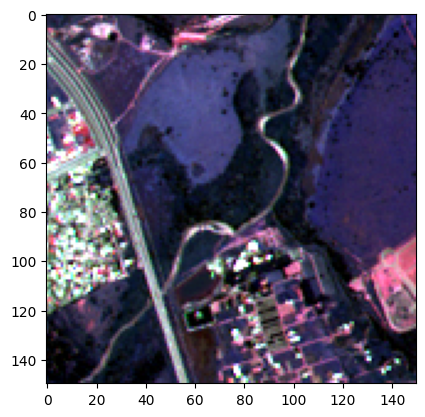

In [21]:
imshow(multi[100:250,100:250,:4], (2,0,1), stretch = (0.02,0.98))

ImageView object:
  Display bands       :  (2, 0, 1)
  Interpolation       :  <default>
  RGB data limits     :
    R: [86.56680253623188, 295.2625]
    G: [144.27569444444447, 244.60452961672473]
    B: [118.51647135416667, 229.18091346153844]

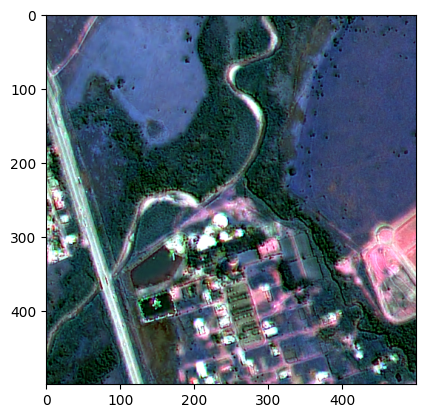

In [22]:
imshow(fusion[500:1000,500:1000,:4], (2,0,1), stretch = (0.02,0.98))

In [23]:
# Armazenando diferentes integrações
fusion_IHS = IHS(multi_r, pan_r)
fusion_IHS_SAR = IHS(multi_sar, VH)
fusion_brovey = brovey(multi_r, pan_r, 0.7)
fusion_RCS = RCS(multi_r, pan_r)

In [26]:
print(fusion_IHS.shape, VH.shape)
print(fusion_IHS_SAR.shape, VH.shape)
print(fusion_brovey.shape, VH.shape)
print(fusion_RCS.shape, VH.shape)

(2540, 2800, 3) (517, 589)
(517, 589, 3) (517, 589)
(2540, 2800, 4) (517, 589)
(2540, 2800, 4) (517, 589)


In [27]:
fusion_IHS_r = reshape_as_raster(fusion_IHS)
fusion_IHS_SAR_r = reshape_as_raster(fusion_IHS_SAR)
fusion_brovey_r = reshape_as_raster(fusion_brovey)
fusion_RCS_r = reshape_as_raster(fusion_RCS)

In [28]:
meta_multi.update({'count': 3})

In [29]:
meta_multi

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 700, 'height': 635, 'count': 3, 'crs': CRS.from_epsg(32722), 'transform': Affine(8.0, 0.0, 720664.0,
       0.0, -8.0, 8197738.0), 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}

In [30]:
meta_pan['height']

2546

In [31]:
with rio.open('IHS_SAR.tif', 'w', **meta_multi) as src:
  src.write(fusion_IHS_SAR_r)

## Operações Aritimétricas

In [32]:
with rio.open('/content/drive/MyDrive/pdi_python/21 - PDI com Python/01 - Pré-Processamento/L71221071_07120010720_DN.tif') as src:
  b1 = src.read(1)
  b2 = src.read(2)
  b3 = src.read(3)
  b4 = src.read(4)
  b5 = src.read(5)
  b7 = src.read(6)

In [33]:
import numpy as np

def expansao(img, percent_min=2, percent_max=98):
    # Cria uma matriz de zeros com o mesmo formato da imagem de entrada
    img2 = np.zeros_like(img)

    # Define os valores mínimo e máximo para expansão
    x, y = 0, 255

    # Calcula os percentis mínimo e máximo da imagem
    pmin = np.percentile(img, percent_min)
    pmax = np.percentile(img, percent_max)

    # Realiza a expansão linear da imagem utilizando os valores mínimo e máximo
    f = x + (img - pmin) * (y - x) / (pmax - pmin)

    # Limita os valores resultantes aos limites mínimo e máximo
    f[f < x] = x
    f[f > y] = y

    # Atribui os valores resultantes à imagem de saída
    img2 = f

    # Retorna a imagem de saída
    return img2


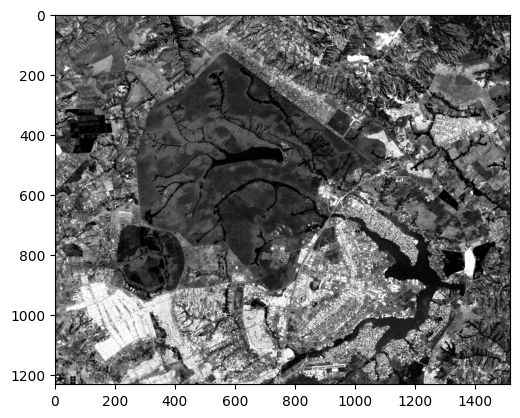

In [35]:
plt.imshow(expansao(b1), cmap='Greys_r');

In [36]:
# Soma de bandas
pan = b1 + b2 + b3
pan

array([[187, 193, 191, ..., 162, 183, 203],
       [184, 192, 194, ..., 154, 160, 171],
       [181, 190, 191, ..., 144, 141, 147],
       ...,
       [153, 166, 170, ..., 148, 153, 157],
       [152, 159, 163, ..., 138, 143, 152],
       [147, 148, 154, ..., 148, 141, 146]], dtype=uint8)

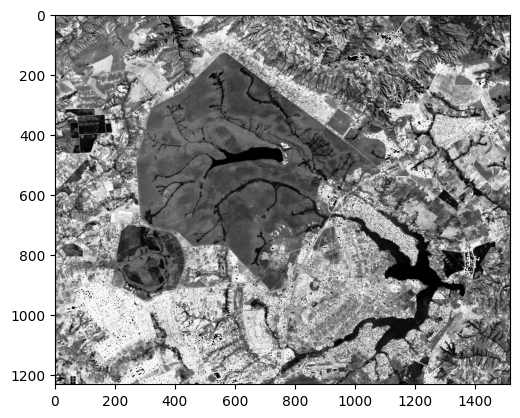

In [37]:
# Visualização de soma
plt.imshow(expansao(pan), cmap='Greys_r')

In [39]:
# Subtração
sub = b3 - b4

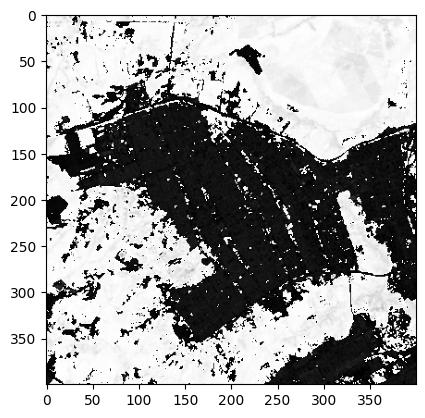

In [40]:
# Visualização da subtração
plt.imshow(expansao(sub[800:1200,0:400]), cmap='Greys_r')

In [60]:
# Razão (NDVI)
ndvi = (b4 - b3) / (b4 + b3)

<ipython-input-60-95c8fe633c2e>:2: RuntimeWarning: divide by zero encountered in true_divide
  ndvi = (b4 - b3) / (b4 + b3)


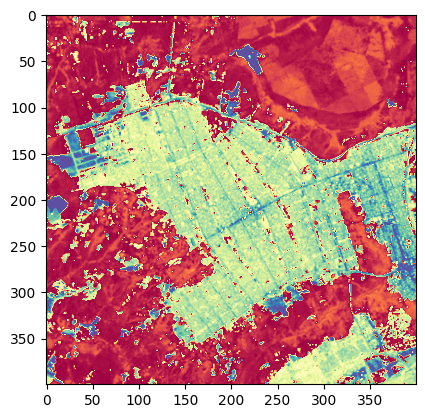

In [66]:
plt.imshow(expansao(ndvi[800:1200,0:400]), cmap='Spectral');

In [62]:
# Multiplicação
pri = (b1 - b2) / (b1 + b2)
spri = (pri + 1) / 2

<ipython-input-62-093df66287a0>:2: RuntimeWarning: divide by zero encountered in true_divide
  pri = (b1 - b2) / (b1 + b2)
<ipython-input-62-093df66287a0>:2: RuntimeWarning: invalid value encountered in true_divide
  pri = (b1 - b2) / (b1 + b2)


In [63]:
CO2flux = (ndvi * spri)

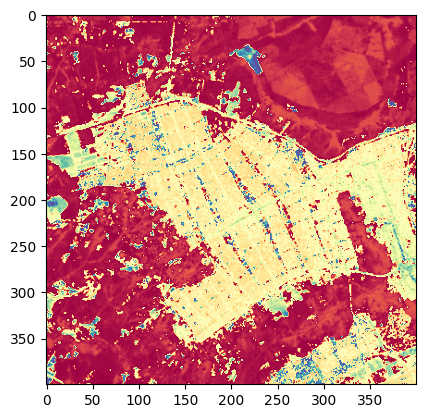

In [67]:
plt.imshow(expansao(CO2flux[800:1200,0:400]), cmap='Spectral');